In [12]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import dgl
import torch
import torch.nn as nn
import torch_geometric
# from torch_geometric import Hetero


# Make the graphs a bit prettier, and bigger
# pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

In [11]:
%pip install torch-scatter==2.0.9 

  Using cached torch_scatter-2.0.9-cp38-cp38-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [5]:
computer2nodeid = dict()
user2nodeid = dict()
process2nodeid = dict()

In [6]:
def auth_filter(row, day_filter):
# day_filter: list of day that used to construct graph. Return True when current row in this list

    day_in_second = 60*60*24
    if np.ceil(int(row[0]) / day_in_second) not in day_filter or row[8] == "Fail" or row[7] == "LogOff" or row[1][0] == "C" or row[2][0] == "C":
        return True
    return False
def process_filter(row, day_filter):
# day_filter: list of day that used to construct graph. Return True when current row in this list

    day_in_second = 60*60*24
    if np.ceil(int(row[0]) / day_in_second) not in day_filter or row[4] == "End":
        return True
    return False

In [7]:
from csv import reader
# open file in read mode
count = 0
day_in_second = 60*60*24
day_filter = [2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 21, 22, 23, 27, 28, 29, 30] # only get data from this list of day
user_comp_dict = set()
comp_comp_dict = set()
user_user_dict = set()
with open('/home/andrewngo/Desktop/LANL_data/auth_1000000.txt', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        if auth_filter(row, day_filter):
            continue
#         if np.ceil(int(row[0]) / day_in_second) > 10:
#             break
        count = count + 1
        if count % 1000000 == 0:
            print(str(count/1000000) + "Mth lines")
        source_user     = row[1].split("@")[0]
        des_user        = row[2].split("@")[0]
        source_computer = row[3]
        des_computer    = row[4]
        if source_user not in user2nodeid:
            user2nodeid[source_user] = len(user2nodeid) 
        if des_user not in user2nodeid:
            user2nodeid[des_user] = len(user2nodeid) 
        if source_computer not in computer2nodeid:
            computer2nodeid[source_computer] = len(computer2nodeid) 
        if des_computer not in computer2nodeid:
            computer2nodeid[des_computer] = len(computer2nodeid)
# Comp -> comp edge
        if source_computer != des_computer:
            comp_comp_dict.add((computer2nodeid[source_computer], computer2nodeid[des_computer]))
# user -> comp edge
        user_comp_dict.add((computer2nodeid[source_computer], user2nodeid[source_user]))
        user_comp_dict.add((computer2nodeid[des_computer], user2nodeid[des_user]))
# user -> user edge
        if source_user != des_user:
            user_user_dict.add((user2nodeid[source_user], user2nodeid[des_user]))
            
# df = pd.DataFrame (df)
# df

In [11]:
from csv import reader
# open file in read mode

count = 0
day_in_second = 60*60*24
day_filter = [2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 21, 22, 23, 27, 28, 29, 30] # only get data from this list of day
df_proc = []
comp_proc_dict = set()
with open('/home/andrewngo/Desktop/LANL_data/proc_1000000.txt', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
#         if np.ceil(int(row[0]) / day_in_second) > 10:
#             break
        if process_filter(row, day_filter):
            continue
        count = count + 1
        if count % 10000000 == 0:
            print(str(count/1000000) + "Mth lines")
        # row variable is a list that represents a row in csv
        
        if row[2] not in computer2nodeid:
            computer2nodeid[row[2]] = len(computer2nodeid)
            
        if row[3] not in process2nodeid:
            process2nodeid[row[3]] = len(process2nodeid)   
        
        comp_proc_dict.add((computer2nodeid[row[2]], process2nodeid[row[3]]))

# df_proc = pd.DataFrame (df_proc)
# df_proc
len(comp_proc_dict) 

168872

In [11]:
malicious_edge_dict = set()
malicious_edge_path = set()
malicious_edge_path_tmp = []
with open('/home/andrewngo/Desktop/LANL_data/redteam.txt', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        user        = row[1].split("@")[0]
        source_computer = row[2]
        des_computer    = row[3]
        if source_computer not in computer2nodeid:
#             print("never seen")
            computer2nodeid[source_computer] = len(computer2nodeid)
            
        if des_computer not in computer2nodeid:
#             print("never seen")
            computer2nodeid[des_computer] = len(computer2nodeid)
            
        if user not in computer2nodeid:
#             print("never seen")
            user2nodeid[user] = len(user2nodeid)
            
        user_comp_dict.add((user2nodeid[user], computer2nodeid[source_computer]))
        user_comp_dict.add((user2nodeid[user], computer2nodeid[des_computer]))
        
        malicious_edge_dict.add((user2nodeid[user], computer2nodeid[source_computer]))
        malicious_edge_dict.add((user2nodeid[user], computer2nodeid[des_computer]))
        malicious_edge_path.add((computer2nodeid[source_computer], user2nodeid[user], computer2nodeid[des_computer]))
        malicious_edge_path_tmp.append((computer2nodeid[source_computer], user2nodeid[user], computer2nodeid[des_computer]))


In [17]:
len(malicious_edge_path)

312

In [13]:
torch.save(malicious_edge_path,"test.pt")

In [16]:
temp = torch.load("test.pt")
len(temp)

312

In [20]:
import os.path as osp
path = osp.join(osp.dirname(osp.realpath(__file__)), '../../data/AMiner')
path

NameError: name '__file__' is not defined

In [7]:
df_red = pd.read_csv('/home/andrewngo/Desktop/LANL_data/redteam.txt', sep =',' , header=None)
df_red

,0,1,2,3
0,150885,U620@DOM1,C17693,C1003
1,151036,U748@DOM1,C17693,C305
2,151648,U748@DOM1,C17693,C728
3,151993,U6115@DOM1,C17693,C1173
4,153792,U636@DOM1,C17693,C294
...,...,...,...,...
744,2552687,U655@DOM1,C17693,C828
745,2552687,U655@DOM1,C17693,C828
746,2552687,U655@DOM1,C17693,C828
747,2552687,U655@DOM1,C17693,C828


In [31]:
path[1]

tensor([[0.3719, 0.6078, 0.4395, 0.5225, 0.8768]])

In [28]:
path = [torch.rand(1,5), torch.rand(1,5), torch.rand(1,5), torch.rand(1,5)] 
new_path = []
for i in range(len(path)):
    new_path.append(path[i][:3])
    new_path.append(path[i][2:])
new_path
    
    

[tensor([[0.2804, 0.5771, 0.7517, 0.4052, 0.6434]]),
 tensor([], size=(0, 5)),
 tensor([[0.3719, 0.6078, 0.4395, 0.5225, 0.8768]]),
 tensor([], size=(0, 5)),
 tensor([[0.3485, 0.7317, 0.0055, 0.9565, 0.5372]]),
 tensor([], size=(0, 5)),
 tensor([[0.9032, 0.8363, 0.8791, 0.2006, 0.1640]]),
 tensor([], size=(0, 5))]

# DGL Graph

In [16]:
data_dict = dict()
data_dict[('Computer', 'Connect', 'Computer')] = list(comp_comp_dict)
data_dict[('User', 'Logon', 'Computer')] = list(user_comp_dict)
data_dict[('User', 'SwitchUser', 'User')] = list(user_user_dict)
data_dict[('Computer', 'Create', 'Process')] = list(comp_proc_dict)

In [17]:
g = dgl.heterograph(data_dict)
g

Graph(num_nodes={'Computer': 12061, 'Process': 1883, 'User': 10382},
      num_edges={('Computer', 'Connect', 'Computer'): 31983, ('Computer', 'Create', 'Process'): 90359, ('User', 'Logon', 'Computer'): 46951, ('User', 'SwitchUser', 'User'): 161},
      metagraph=[('Computer', 'Computer', 'Connect'), ('Computer', 'Process', 'Create'), ('User', 'Computer', 'Logon'), ('User', 'User', 'SwitchUser')])

# Pytorch_geometric graph

In [25]:
data_dict[('Computer', 'Connect', 'Computer')] = torch.transpose(torch.LongTensor(data_dict[('Computer', 'Connect', 'Computer')]), 0, 1) 

data_dict[('User', 'Logon', 'Computer')] = torch.transpose(torch.LongTensor(data_dict[('User', 'Logon', 'Computer')]), 0, 1) 

data_dict[('User', 'SwitchUser', 'User')] = torch.transpose(torch.LongTensor(data_dict[('User', 'SwitchUser', 'User')]), 0, 1) 

data_dict[('Computer', 'Create', 'Process')] = torch.transpose(torch.LongTensor(data_dict[('Computer', 'Create', 'Process')]), 0, 1) 

In [26]:
data_dict[('User', 'SwitchUser', 'User')]

tensor([[6238, 5976, 5236,  ..., 8517, 8651, 8255],
        [  29,   29, 4191,  ...,   46,   46,   46]])

In [7]:
x = torch.arange(14).view(2, 7)
torch.flip(x, [0, 1])

tensor([[13, 12, 11, 10,  9,  8,  7],
        [ 6,  5,  4,  3,  2,  1,  0]])

In [22]:
data_dict[('Computer', 'Connect', 'Computer')]

tensor([[6238,   29],
        [5976,   29],
        [5236, 4191],
        ...,
        [8517,   46],
        [8651,   46],
        [8255,   46]])

In [12]:
from torch_geometric.data import HeteroData

data = HeteroData()
data['Computer', 'Connect', 'Computer'].edge_index = data_dict[('Computer', 'Connect', 'Computer')]
data['User', 'Logon', 'Computer'].edge_index = data_dict[('User', 'Logon', 'Computer')]
data['User', 'SwitchUser', 'User'].edge_index = data_dict[('User', 'SwitchUser', 'User')]
data['Computer', 'Create', 'Process'].edge_index = data_dict[('Computer', 'Create', 'Process')]

ModuleNotFoundError: No module named 'torch_geometric'

In [56]:
from csv import reader
# open file in read mode
count = 0
day_in_second = 60*60*24
day_filter = [2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 21, 22, 23, 27, 28, 29, 30] # only get data from this list of day
user_comp_dict = set()
comp_comp_dict = set()
user_user_dict = set()
with open('/home/andrewngo/Desktop/LANL_data/auth.txt', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        if auth_filter(row, day_filter):
            continue
        if np.ceil(int(row[0]) / day_in_second) > 30:
            break
        count = count + 1
        if count % 1000000 == 0:
            print(str(count/1000000) + "Mth lines")
        source_user     = row[1].split("@")[0]
        des_user        = row[2].split("@")[0]
        source_computer = row[3]
        des_computer    = row[4]
        if source_user not in user2nodeid:
            user2nodeid[source_user] = len(user2nodeid) 
        if des_user not in user2nodeid:
            user2nodeid[des_user] = len(user2nodeid) 
        if source_computer not in computer2nodeid:
            computer2nodeid[source_computer] = len(computer2nodeid) 
        if des_computer not in computer2nodeid:
            computer2nodeid[des_computer] = len(computer2nodeid)
# Comp -> comp edge
        if source_computer != des_computer:
            comp_comp_dict.add((computer2nodeid[source_computer], computer2nodeid[des_computer]))
# user -> comp edge
        user_comp_dict.add((computer2nodeid[source_computer], user2nodeid[source_user]))
        user_comp_dict.add((computer2nodeid[des_computer], user2nodeid[des_user]))
# user -> user edge
        if source_user != des_user:
            user_user_dict.add((user2nodeid[source_user], user2nodeid[des_user]))
        temp = (row[0], source_user, row[3], row[4])
        if temp in df_red_tuple:
            df_red_tuple[temp] = df_red_tuple[temp] + 1
            
# df = pd.DataFrame (df)
# df 
df_red_tuple

1.0Mth lines
2.0Mth lines
3.0Mth lines
4.0Mth lines
5.0Mth lines
6.0Mth lines
7.0Mth lines
8.0Mth lines
9.0Mth lines
10.0Mth lines
11.0Mth lines
12.0Mth lines
13.0Mth lines
14.0Mth lines
15.0Mth lines
16.0Mth lines
17.0Mth lines
18.0Mth lines
19.0Mth lines
20.0Mth lines
21.0Mth lines
22.0Mth lines
23.0Mth lines
24.0Mth lines
25.0Mth lines
26.0Mth lines
27.0Mth lines
28.0Mth lines
29.0Mth lines
30.0Mth lines
31.0Mth lines
32.0Mth lines
33.0Mth lines
34.0Mth lines
35.0Mth lines
36.0Mth lines
37.0Mth lines
38.0Mth lines
39.0Mth lines
40.0Mth lines
41.0Mth lines
42.0Mth lines
43.0Mth lines
44.0Mth lines
45.0Mth lines
46.0Mth lines
47.0Mth lines
48.0Mth lines
49.0Mth lines
50.0Mth lines
51.0Mth lines
52.0Mth lines
53.0Mth lines
54.0Mth lines
55.0Mth lines
56.0Mth lines
57.0Mth lines
58.0Mth lines
59.0Mth lines
60.0Mth lines
61.0Mth lines
62.0Mth lines
63.0Mth lines
64.0Mth lines
65.0Mth lines
66.0Mth lines
67.0Mth lines
68.0Mth lines
69.0Mth lines
70.0Mth lines
71.0Mth lines
72.0Mth lines
7

{(150885, 'U620', 'C17693', 'C1003'): 0,
 (151036, 'U748', 'C17693', 'C305'): 0,
 (151648, 'U748', 'C17693', 'C728'): 0,
 (151993, 'U6115', 'C17693', 'C1173'): 0,
 (153792, 'U636', 'C17693', 'C294'): 0,
 (155219, 'U748', 'C17693', 'C5693'): 0,
 (155399, 'U748', 'C17693', 'C152'): 0,
 (155460, 'U748', 'C17693', 'C2341'): 0,
 (155591, 'U748', 'C17693', 'C332'): 0,
 (156658, 'U748', 'C17693', 'C4280'): 0,
 (210086, 'U748', 'C18025', 'C1493'): 0,
 (210294, 'U748', 'C18025', 'C1493'): 0,
 (210312, 'U748', 'C18025', 'C1493'): 0,
 (218418, 'U748', 'C17693', 'C504'): 0,
 (227052, 'U748', 'C17693', 'C148'): 0,
 (227408, 'U748', 'C17693', 'C148'): 0,
 (227520, 'U748', 'C17693', 'C148'): 0,
 (227780, 'U748', 'C17693', 'C148'): 0,
 (228024, 'U748', 'C17693', 'C148'): 0,
 (228150, 'U748', 'C17693', 'C148'): 0,
 (228642, 'U1723', 'C17693', 'C231'): 0,
 (228658, 'U1723', 'C17693', 'C231'): 0,
 (229046, 'U1723', 'C17693', 'C231'): 0,
 (230395, 'U1723', 'C17693', 'C1003'): 0,
 (234667, 'U748', 'C17693'

In [1]:
df=pd.read_csv('/home/andrewngo/Desktop/LANL_data/auth_1000000.txt', sep =',' , header=None)
df

NameError: name 'pd' is not defined

In [38]:
df=pd.read_csv('/home/andrewngo/Desktop/LANL_data/auth_1000000.txt', sep =',' , header=None)
df_red = pd.read_csv('/home/andrewngo/Desktop/LANL_data/redteam.txt', sep =',' , header=None)
df_proc=pd.read_csv('/home/andrewngo/Desktop/LANL_data/proc_1000000.txt', sep =',' , header=None)

In [36]:
df_red
# df_red_tuple = list(df_red.to_records())
df_red[1], _= zip(*df_red[1].str.split('@').tolist())
df_red_tuple = list(df_red.itertuples(index=False, name=None))
df_red_tuple = {i : 0 for i in df_red_tuple}
df_red_tuple

{(150885, 'U620', 'C17693', 'C1003'): 0,
 (151036, 'U748', 'C17693', 'C305'): 0,
 (151648, 'U748', 'C17693', 'C728'): 0,
 (151993, 'U6115', 'C17693', 'C1173'): 0,
 (153792, 'U636', 'C17693', 'C294'): 0,
 (155219, 'U748', 'C17693', 'C5693'): 0,
 (155399, 'U748', 'C17693', 'C152'): 0,
 (155460, 'U748', 'C17693', 'C2341'): 0,
 (155591, 'U748', 'C17693', 'C332'): 0,
 (156658, 'U748', 'C17693', 'C4280'): 0,
 (210086, 'U748', 'C18025', 'C1493'): 0,
 (210294, 'U748', 'C18025', 'C1493'): 0,
 (210312, 'U748', 'C18025', 'C1493'): 0,
 (218418, 'U748', 'C17693', 'C504'): 0,
 (227052, 'U748', 'C17693', 'C148'): 0,
 (227408, 'U748', 'C17693', 'C148'): 0,
 (227520, 'U748', 'C17693', 'C148'): 0,
 (227780, 'U748', 'C17693', 'C148'): 0,
 (228024, 'U748', 'C17693', 'C148'): 0,
 (228150, 'U748', 'C17693', 'C148'): 0,
 (228642, 'U1723', 'C17693', 'C231'): 0,
 (228658, 'U1723', 'C17693', 'C231'): 0,
 (229046, 'U1723', 'C17693', 'C231'): 0,
 (230395, 'U1723', 'C17693', 'C1003'): 0,
 (234667, 'U748', 'C17693'

In [37]:
len(df_red_tuple)

715

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
temp = [(9605, 11336, 6490), (9605, 11336, 4702), (9605, 11336, 10700), (9605, 11336, 6270)]
temp = [torch.LongTensor(i).to(device) for i in temp]
temp

[tensor([ 9605, 11336,  6490], device='cuda:0'),
 tensor([ 9605, 11336,  4702], device='cuda:0'),
 tensor([ 9605, 11336, 10700], device='cuda:0'),
 tensor([ 9605, 11336,  6270], device='cuda:0')]

In [175]:
df = df.sort_values(by=[0]).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8
0,4,C436$@DOM1,SYSTEM@C436,C436,C436,Negotiate,Service,LogOn,Success
1,13,C1640$@DOM1,C1640$@DOM1,C2110,C2106,Kerberos,Network,LogOn,Success
2,69,U1167@DOM1,U1167@DOM1,C529,C529,?,Network,LogOff,Success
3,91,C1617$@DOM1,C1617$@DOM1,C1618,C553,Kerberos,Network,LogOn,Success
4,97,U3@DOM1,U3@DOM1,C528,C528,?,Network,LogOff,Success
...,...,...,...,...,...,...,...,...,...
999995,5011172,C2441$@DOM1,C2441$@DOM1,C2442,C586,?,?,TGS,Success
999996,5011184,ANONYMOUS LOGON@C457,ANONYMOUS LOGON@C457,C457,C457,?,Network,LogOff,Success
999997,5011186,U4978@DOM1,U4978@DOM1,C24517,C586,Kerberos,Network,LogOn,Success
999998,5011195,C18656$@DOM1,C18656$@DOM1,C18656,C625,Kerberos,Network,LogOn,Success


In [ ]:
# normal 
# malicious (Lateral movement activites)



# unsupervised learnign 

# training : normal 
# validation & testing: normal adn malicious 

    
    

# graph -> metapath2vec -> path embedding  -> autoencoder -> malicious/normal  
    
    

In [176]:
len(set(df[1]))

29122

In [177]:
set(df[7])

{'AuthMap', 'LogOff', 'LogOn', 'ScreenLock', 'ScreenUnlock', 'TGS', 'TGT'}

In [178]:
set(df[6])

{'?',
 'Batch',
 'CachedInteractive',
 'Interactive',
 'Network',
 'NetworkCleartext',
 'NewCredentials',
 'RemoteInteractive',
 'Service',
 'Unlock'}

In [179]:
len(set(df_red[2]))

4

In [180]:
df_proc = df_proc.sort_values([0]).reset_index(drop=True)
df_proc

,0,1,2,3,4
0,1,C1551$@DOM1,C1551,P4,Start
1,1,C1815$@DOM1,C1815,P4,Start
2,2,C1287$@DOM1,C1287,P3,Start
3,2,C1108$@DOM1,C1108,P3,Start
4,2,C295$@DOM1,C295,P1,Start
...,...,...,...,...,...
999995,5011143,C3718$@DOM1,C3718,P7,Start
999996,5011143,C3718$@DOM1,C3718,P5,Start
999997,5011145,LOCAL SERVICE@C2103,C2103,P22,Start
999998,5011180,C2254$@DOM1,C2254,P5,Start


In [181]:
df_proc.groupby([2,4]).count()

0    1    3
2     4                   
C1    End    526  526  526
      Start  471  471  471
C10   End     45   45   45
      Start   53   53   53
C100  Start  138  138  138
...          ...  ...  ...
C9994 Start   85   85   85
C9996 End      1    1    1
      Start   91   91   91
C9997 End      3    3    3
      Start    2    2    2

[17908 rows x 3 columns]

In [182]:
df_red

,0,1,2,3
0,150885,U620@DOM1,C17693,C1003
1,151036,U748@DOM1,C17693,C305
2,151648,U748@DOM1,C17693,C728
3,151993,U6115@DOM1,C17693,C1173
4,153792,U636@DOM1,C17693,C294
...,...,...,...,...
744,2552687,U655@DOM1,C17693,C828
745,2552687,U655@DOM1,C17693,C828
746,2552687,U655@DOM1,C17693,C828
747,2552687,U655@DOM1,C17693,C828


In [183]:
len(set(df_red[0]))

712

In [184]:
df_red = df_red.sort_values([0])
df_red

,0,1,2,3
0,150885,U620@DOM1,C17693,C1003
1,151036,U748@DOM1,C17693,C305
2,151648,U748@DOM1,C17693,C728
3,151993,U6115@DOM1,C17693,C1173
4,153792,U636@DOM1,C17693,C294
...,...,...,...,...
744,2552687,U655@DOM1,C17693,C828
745,2552687,U655@DOM1,C17693,C828
746,2552687,U655@DOM1,C17693,C828
747,2552687,U655@DOM1,C17693,C828


In [185]:
len(set(df_red[2]))

4

In [186]:
len(set(df_red[1]))

104

In [187]:
len(set(df_red[2]))

4

In [188]:
len(set(df_red[3]))

301

In [189]:
df[8].value_counts()

Success    987846
Fail        12154
Name: 8, dtype: int64

In [190]:
7626505167/59

129262799.44067797

Command to split txt into small files

# Red team label 

auth.txtx file: “time, source user@domain, destination user@domain, source computer, destination computer, authentication type, logon type, authentication orientation, success/failure” 

+ Source User-> Source Computer: Logon
+ Source Computer -> Destination Computer: Connection
+ Source User -> Process: Create
+ Source Computer -> Process: Create

Redteam file: “time,user@domain,source computer,destination computer”

proc.txt: “time,user@domain,computer,process name,start/end” 

In [9]:
day_in_second = 60*60*24
day_in_second

86400

In [12]:
# get dictionary of day that involved malicious activities
df_red["time_day"] = df_red[0] / day_in_second
df_red["time_day_round"] = np.ceil(df_red[0] / day_in_second)
df_red

,0,1,2,3,time_day,time_day_round
0,150885,U620@DOM1,C17693,C1003,1.746354,2.0
1,151036,U748@DOM1,C17693,C305,1.748102,2.0
2,151648,U748@DOM1,C17693,C728,1.755185,2.0
3,151993,U6115@DOM1,C17693,C1173,1.759178,2.0
4,153792,U636@DOM1,C17693,C294,1.780000,2.0
...,...,...,...,...,...,...
744,2552687,U655@DOM1,C17693,C828,29.544988,30.0
745,2552687,U655@DOM1,C17693,C828,29.544988,30.0
746,2552687,U655@DOM1,C17693,C828,29.544988,30.0
747,2552687,U655@DOM1,C17693,C828,29.544988,30.0


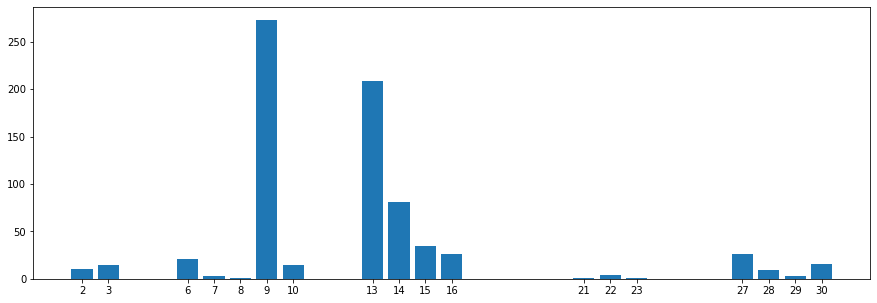

In [13]:
import matplotlib.pyplot as plt
import numpy as np


# max length path
max_length = 40
# path_from_user
# x = np.zeros(shape=max_length)
x = list(df_red["time_day_round"])
# plot histogram  
labels, counts = np.unique(x, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()
plt.show() 

In [23]:
from csv import reader
# open file in read mode
day_filter = [2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 21, 22, 23, 27, 28, 29, 30] # only get data from this list of day
with open('/home/andrewngo/Desktop/LANL_data/auth_1000000.txt', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        count = 1

In [37]:
temp = "U9862@DOM1"
temp.split("@")[0]

'U9862'

In [ ]:
len(user)

In [45]:
len(comp_comp_dict)

31983

In [44]:
len(comp_user_dict)

46951

In [43]:
len(user_user_dict)

161

10000000th lines
20000000th lines
30000000th lines
40000000th lines
50000000th lines
60000000th lines
70000000th lines


1128016

In [27]:
len(set(comp_proc_dict))

1128016

In [23]:
len(computer2nodeid)

10903

In [25]:
len(process2nodeid)

22486

In [4]:
df_proc

,0,1,2,3,4,5,6,7,8
0,1185549,U9862@DOM1,U9862@DOM1,C20781,C529,Kerberos,Network,LogOn,Success


In [12]:
np.ceil(1185549 / day_in_second)

14.0

In [15]:
labels

array([ 2.,  3.,  6.,  7.,  8.,  9., 10., 13., 14., 15., 16., 21., 22.,
       23., 27., 28., 29., 30.])

In [191]:
# Create set of tuple that indicate the malicious log
red_set = []
for idx_red, row_red in df_red.iterrows():
    red_set.append(tuple(row_red))

red_set = set(red_set)
red_set

{(150885, 'U620@DOM1', 'C17693', 'C1003'),
 (151036, 'U748@DOM1', 'C17693', 'C305'),
 (151648, 'U748@DOM1', 'C17693', 'C728'),
 (151993, 'U6115@DOM1', 'C17693', 'C1173'),
 (153792, 'U636@DOM1', 'C17693', 'C294'),
 (155219, 'U748@DOM1', 'C17693', 'C5693'),
 (155399, 'U748@DOM1', 'C17693', 'C152'),
 (155460, 'U748@DOM1', 'C17693', 'C2341'),
 (155591, 'U748@DOM1', 'C17693', 'C332'),
 (156658, 'U748@DOM1', 'C17693', 'C4280'),
 (210086, 'U748@DOM1', 'C18025', 'C1493'),
 (210294, 'U748@DOM1', 'C18025', 'C1493'),
 (210312, 'U748@DOM1', 'C18025', 'C1493'),
 (218418, 'U748@DOM1', 'C17693', 'C504'),
 (227052, 'U748@DOM1', 'C17693', 'C148'),
 (227408, 'U748@DOM1', 'C17693', 'C148'),
 (227520, 'U748@DOM1', 'C17693', 'C148'),
 (227780, 'U748@DOM1', 'C17693', 'C148'),
 (228024, 'U748@DOM1', 'C17693', 'C148'),
 (228150, 'U748@DOM1', 'C17693', 'C148'),
 (228642, 'U1723@DOM1', 'C17693', 'C231'),
 (228658, 'U1723@DOM1', 'C17693', 'C231'),
 (229046, 'U1723@DOM1', 'C17693', 'C231'),
 (230395, 'U1723@DOM1'

In [192]:
# Add is_malicious columns on the original df
df_compare = df[[0, 1, 3, 4]]
df_compare_dict = df_compare.to_dict('records')
is_malicious = []
for row in tqdm(df_compare_dict):
    row = (row[0], row[1], row[3], row[4])
    if tuple(row) in red_set:
        print("is_malicious")
        is_malicious.append(1)
    else:
        is_malicious.append(0)
        
df['is_malicious'] = is_malicious

100%|██████████| 1000000/1000000 [00:00<00:00, 1468902.43it/s]


In [39]:
df["source_user"], df["source_domain"] = zip(*df[1].str.split('@').tolist())
df["source_user"]=df["source_user"].str.rstrip('$')
df["destination_user"], df["destination_domain"] = zip(*df[2].str.split('@').tolist())
df["destination_user"]=df["destination_user"].str.rstrip('$')
df['same_user']=(df['destination_user']==df['source_user'])
df['same_domain']=(df['destination_domain']==df['source_domain'])

df['source_user_comp_same']=(df[3]==df['source_user'])
df['destination_user_comp_same']=(df['destination_user']==df[4])
df['same_comp']=(df[3]==df[4])
df['source_domain_comp_same']=(df[3]==df['source_domain'])
df['destination_domain_comp_same']=(df['destination_domain']==df[4])
df[5].loc[df[5].str.contains("MICROSOFT")] = "MICROSOFT_AUTHENTICATION_PACKET_V1_0"

/home/andrewngo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [40]:
df["source_start_with_U"] = df.source_user.str.startswith('U')
df["destination_start_with_U"] = df.destination_user.str.startswith('U')
df["source_start_with_C"] = df.source_user.str.startswith('C')
df["destination_start_with_C"] = df.destination_user.str.startswith('C')

In [43]:
df[df["source_start_with_U"]].reset_index(drop=False)

,index,0,1,2,3,4,5,6,7,8,source_user,source_domain,destination_user,destination_domain,same_user,same_domain,source_user_comp_same,destination_user_comp_same,same_comp,source_domain_comp_same,destination_domain_comp_same,source_start_with_U,destination_start_with_U,source_start_with_C,destination_start_with_C
0,0,1185549,U9862@DOM1,U9862@DOM1,C20781,C529,Kerberos,Network,LogOn,Success,U9862,DOM1,U9862,DOM1,True,True,False,False,False,False,False,True,True,False,False
1,7,3147067,U1682@DOM1,U1682@DOM1,C3388,C3388,?,Network,LogOff,Success,U1682,DOM1,U1682,DOM1,True,True,False,False,True,False,False,True,True,False,False
2,9,4976416,U4787@DOM1,U4787@DOM1,C1065,C1065,?,Network,LogOff,Success,U4787,DOM1,U4787,DOM1,True,True,False,False,True,False,False,True,True,False,False
3,10,1374421,U9292@DOM1,U9292@DOM1,C529,C529,?,Network,LogOff,Success,U9292,DOM1,U9292,DOM1,True,True,False,False,True,False,False,True,True,False,False
4,13,3723015,U1191@DOM1,U1191@DOM1,C4837,C2162,Kerberos,Network,LogOn,Success,U1191,DOM1,U1191,DOM1,True,True,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325176,999983,2015403,U5521@DOM1,U5521@DOM1,C12562,C1015,Kerberos,Network,LogOn,Success,U5521,DOM1,U5521,DOM1,True,True,False,False,False,False,False,True,True,False,False
325177,999984,4886275,U10969@DOM1,U10969@DOM1,C1795,C1794,?,?,TGS,Success,U10969,DOM1,U10969,DOM1,True,True,False,False,False,False,False,True,True,False,False
325178,999987,170238,U6109@DOM1,U6109@DOM1,C13983,C529,Kerberos,Network,LogOn,Success,U6109,DOM1,U6109,DOM1,True,True,False,False,False,False,False,True,True,False,False
325179,999988,4225320,U8406@DOM1,U8406@DOM1,C10,C10,?,Network,LogOff,Success,U8406,DOM1,U8406,DOM1,True,True,False,False,True,False,False,True,True,False,False


In [44]:
count = 0
for i in df["destination_start_with_U"]:
    if i == True:
        count = count + 1
count

325611

# Graph Contruction

In [196]:
# construct LOGON graph based on "?" authentication
# Step 1: construct nodeid dictionary for user, process and computer (for easier look up)

In [213]:
df = df[df[8] == "Success"] # df with success authentication only
df
# 

# there is some duplicated edge in the graph (e.g a user could logon to a computer many time)
# we temporary ignore these duplicated edge, i.e ignore the temporal information of the graph
reduced_edge = True 

In [200]:
df.groupby([5,6,7,"source_start_with_U"]).count()

0       1       2       3       4       8  is_malicious  source_user  source_domain  destination_user  destination_domain  same_user  same_domain  source_user_comp_same  destination_user_comp_same  same_comp  source_domain_comp_same  destination_domain_comp_same  destination_start_with_U  source_start_with_C  destination_start_with_C
5                                    6                 7            source_start_with_U                                                                                                                                                                                                                                                                                                                                                      
?                                    ?                 AuthMap      False                  1746    1746    1746    1746    1746    1746          1746         1746           1746              1746                1746       1746         1746                   1746                        1746       1746                     1746                          1746                      1746                 1746                      1746
                                                                    True                   7218    7218    7218    7218    7218    7218          7218         7218           7218              7218                7218       7218         7218                   7218                        7218       7218                     7218                          7218                      7218                 7218                      7218
                                                       LogOn        False                    93      93      93      93      93      93            93           93             93                93                  93         93           93                     93                          93         93                       93                            93                        93                   93                        93
                                                       ScreenLock   True                     69      69      69      69      69      69            69           69             69                69                  69         69           69                     69                          69         69                       69                            69                        69                   69                        69
                                                       ScreenUnlock True                     86      86      86      86      86      86            86           86             86                86                  86         86           86                     86                          86         86                       86                            86                        86                   86                        86
                                                       TGS          False                 51030   51030   51030   51030   51030   51030         51030        51030          51030             51030               51030      51030        51030                  51030                       51030      51030                    51030                         51030                     51030                51030                     51030
                                                                    True                  43086   43086   43086   43086   43086   43086         43086        43086          43086             43086               43086      43086        43086                  43086                       43086      43086                    43086                         43086                     43086                43086                     43086
                                                       TGT          False                 13499   13499   13499   13499   13499   13499         13499        13499          13499             13499               13499      134

In [201]:
# generate user to nodeid lookup dictionary
set_user = set(df[~df["source_start_with_C"]]["source_user"])
set_user.update(list(set(df[~df["destination_start_with_C"]]["destination_user"])))
set_user = list(set_user)
user2nodeid = {set_user[i]: i for i in range(len(set_user))}
len(user2nodeid)

9596

In [203]:
# generate computer to nodeid lookup dictionary
set_computer = set(df[3])
set_computer.update(list(set(df[4])))
set_computer = list(set_computer)
computer2nodeid = {set_computer[i]: i for i in range(len(set_computer))}
len(computer2nodeid)

14122

In [234]:
set_proc = list(set(df_proc[3]))
# set_computer = list(set_computer)
proc2nodeid = {set_proc[i]: i for i in range(len(set_proc))}
proc2nodeid

{'P1897': 0,
 'P1727': 1,
 'P187': 2,
 'P2152': 3,
 'P2906': 4,
 'P264': 5,
 'P803': 6,
 'P329': 7,
 'P4004': 8,
 'P3226': 9,
 'P41221': 10,
 'P1560': 11,
 'P2423': 12,
 'P1106': 13,
 'P930': 14,
 'P3110': 15,
 'P12655': 16,
 'P170': 17,
 'P12889': 18,
 'P31935': 19,
 'P9830': 20,
 'P7535': 21,
 'P3507': 22,
 'P2043': 23,
 'P345': 24,
 'P13944': 25,
 'P1019': 26,
 'P30': 27,
 'P2818': 28,
 'P5533': 29,
 'P8548': 30,
 'P13090': 31,
 'P4628': 32,
 'P8476': 33,
 'P26635': 34,
 'P4374': 35,
 'P4187': 36,
 'P4072': 37,
 'P13379': 38,
 'P103': 39,
 'P30472': 40,
 'P3256': 41,
 'P2091': 42,
 'P820': 43,
 'P6738': 44,
 'P1734': 45,
 'P100': 46,
 'P3924': 47,
 'P229': 48,
 'P2094': 49,
 'P10118': 50,
 'P3660': 51,
 'P29': 52,
 'P986': 53,
 'P22': 54,
 'P4904': 55,
 'P1368': 56,
 'P10': 57,
 'P3685': 58,
 'P5177': 59,
 'P489': 60,
 'P1232': 61,
 'P220': 62,
 'P3973': 63,
 'P780': 64,
 'P1543': 65,
 'P431': 66,
 'P402': 67,
 'P2161': 68,
 'P5484': 69,
 'P1962': 70,
 'P2966': 71,
 'P833': 72,
 'P1

In [204]:
# Step 2: contruct comp -> comp using same_comp

In [215]:
mask_comp_comp = ~df["same_comp"]
if reduced_edge == True:
    comp_source = list(set(map(computer2nodeid.get,df[mask_comp_comp][3]))) # convert computer to nodeid
    comp_des = list(set(map(computer2nodeid.get,df[mask_comp_comp][4]))) # convert computer to nodeid
else:
    comp_source = list(map(computer2nodeid.get,df[mask_comp_comp][3])) # convert computer to nodeid
    comp_des = list(map(computer2nodeid.get,df[mask_comp_comp][4])) # convert computer to nodeid    

comp_comp_dict = list(zip(comp_source, comp_des))
comp_comp_dict

[(0, 8194),
 (1, 2),
 (2, 4),
 (3, 5),
 (4, 7),
 (5, 8200),
 (6, 8201),
 (7, 8203),
 (8, 12),
 (9, 8205),
 (10, 8206),
 (11, 8207),
 (12, 8208),
 (13, 13),
 (14, 8210),
 (15, 11),
 (16, 8212),
 (17, 8214),
 (18, 23),
 (19, 24),
 (20, 8217),
 (21, 8220),
 (22, 30),
 (23, 32),
 (24, 35),
 (25, 36),
 (26, 8229),
 (27, 37),
 (28, 8228),
 (29, 8233),
 (30, 8235),
 (31, 45),
 (32, 8237),
 (33, 47),
 (34, 50),
 (35, 51),
 (36, 57),
 (37, 60),
 (38, 8252),
 (39, 8254),
 (40, 64),
 (41, 65),
 (42, 8258),
 (43, 8257),
 (44, 8256),
 (45, 70),
 (46, 72),
 (47, 73),
 (48, 8266),
 (49, 75),
 (51, 8268),
 (52, 77),
 (53, 8270),
 (54, 78),
 (55, 80),
 (56, 8273),
 (57, 81),
 (58, 83),
 (59, 8275),
 (60, 8274),
 (61, 87),
 (62, 91),
 (63, 92),
 (64, 94),
 (65, 8286),
 (66, 8288),
 (67, 8293),
 (68, 101),
 (69, 8294),
 (71, 103),
 (72, 108),
 (73, 8301),
 (74, 8303),
 (75, 117),
 (76, 8311),
 (77, 120),
 (78, 123),
 (79, 124),
 (80, 8317),
 (81, 8315),
 (82, 8316),
 (83, 8320),
 (84, 128),
 (85, 8318),


In [216]:
# Step 3: contruct user --> comp 
# in this version, we only consider "real" user: in this data, there is the presense of 2 type of user, user start
# with character "U" (U66@DOM1) and with "C" (C436$@DOM1), we think that the C is represent for a computer

In [217]:
# case 1: source and destination user, source and destination computer are the same
mask_user_comp = (~(df["source_start_with_C"] | df["destination_start_with_C"]) & (df["same_comp"] & df["same_user"]))


if reduced_edge == True: 
    user_source = list(set(map(user2nodeid.get,df[mask_user_comp]["source_user"]))) # convert computer to nodeid
    comp_source = list(set(map(computer2nodeid.get,df[mask_user_comp][3]))) # convert computer to nodeid
else:
    user_source = list(map(user2nodeid.get,df[mask_user_comp]["source_user"])) # convert computer to nodeid
    comp_source = list(map(computer2nodeid.get,df[mask_user_comp][3])) # convert computer to nodeid
user_comp_dict_case_1 = list(zip(user_source, comp_source))
print(len(user_comp_dict_case_1))
user_comp_dict = user_comp_dict_case_1


# Case 2: other case
# destination -> comp as 2 difference edge
mask_user_comp = (~(df["source_start_with_C"] | df["destination_start_with_C"]) & ~(df["same_comp"] & df["same_user"]))

if reduced_edge == True: 
    user_source = list(set(map(user2nodeid.get,df[mask_user_comp]["source_user"]))) # convert computer to nodeid
    comp_source = list(set(map(computer2nodeid.get,df[mask_user_comp][3]))) # convert computer to nodeid
    
    user_des = list(set(map(user2nodeid.get,df[mask_user_comp]["destination_user"]))) # convert computer to nodeid
    comp_des = list(set(map(computer2nodeid.get,df[mask_user_comp][4]))) # convert computer to nodeid
else: 
    user_source = list(map(user2nodeid.get,df[mask_user_comp]["source_user"])) # convert computer to nodeid
    comp_source = list(map(computer2nodeid.get,df[mask_user_comp][3])) # convert computer to nodeid
    
    user_des = list(set(user2nodeid.get,df[mask_user_comp]["destination_user"])) # convert computer to nodeid
    comp_des = list(set(computer2nodeid.get,df[mask_user_comp][4])) # convert computer to nodeid  
user_comp_dict_case_2 = list(zip(user_source, comp_source))
user_comp_dict_case_2.extend(list(zip(user_des, comp_des)))

print(len(user_comp_dict_case_2))
user_comp_dict.extend(user_comp_dict_case_2)

user_comp_dict



7710
9830


[(0, 0),
 (1, 2),
 (3, 3),
 (4, 5),
 (6, 7),
 (7, 8),
 (8, 10),
 (9, 11),
 (10, 12),
 (12, 13),
 (13, 15),
 (14, 16),
 (15, 20),
 (16, 21),
 (18, 23),
 (19, 24),
 (20, 28),
 (21, 32),
 (22, 33),
 (23, 34),
 (24, 35),
 (25, 36),
 (26, 38),
 (27, 40),
 (28, 41),
 (29, 42),
 (30, 43),
 (31, 44),
 (32, 45),
 (33, 46),
 (34, 47),
 (35, 51),
 (36, 52),
 (37, 54),
 (38, 56),
 (39, 57),
 (40, 59),
 (41, 60),
 (43, 62),
 (44, 63),
 (45, 65),
 (46, 67),
 (47, 68),
 (48, 71),
 (49, 72),
 (50, 73),
 (51, 74),
 (52, 79),
 (53, 80),
 (54, 81),
 (55, 84),
 (56, 85),
 (57, 86),
 (58, 87),
 (59, 88),
 (60, 89),
 (62, 92),
 (63, 93),
 (64, 96),
 (65, 99),
 (66, 103),
 (67, 104),
 (68, 105),
 (69, 106),
 (70, 108),
 (71, 109),
 (72, 110),
 (73, 113),
 (74, 114),
 (75, 115),
 (76, 116),
 (77, 119),
 (78, 121),
 (79, 122),
 (80, 124),
 (81, 125),
 (82, 127),
 (83, 128),
 (84, 129),
 (85, 130),
 (87, 132),
 (88, 134),
 (90, 135),
 (92, 136),
 (93, 137),
 (94, 140),
 (95, 143),
 (97, 144),
 (98, 145),
 (99, 

In [218]:
# Step 4: User -> User: user switch

In [255]:
mask_user_user = (~(df["source_start_with_C"] | df["destination_start_with_C"]) & ~(df["same_user"]))

if reduced_edge == True: 
    user_source = list(set(map(user2nodeid.get,df[mask_user_comp]["source_user"]))) # convert computer to nodeid
    user_des = list(set(map(user2nodeid.get,df[mask_user_comp]["destination_user"]))) # convert computer to nodeid
else:
    user_source = list(map(user2nodeid.get,df[mask_user_comp]["source_user"])) # convert computer to nodeid
    user_des = list(map(user2nodeid.get,df[mask_user_comp]["destination_user"])) # convert computer to nodeid
    
user_user_dict = list(zip(user_source, user_des))
print(len(user_user_dict))

8946


In [256]:
# Step 5: construct comp -> process

In [257]:
df_proc

,0,1,2,3,4
0,1,C1551$@DOM1,C1551,P4,Start
1,1,C1815$@DOM1,C1815,P4,Start
2,2,C1287$@DOM1,C1287,P3,Start
3,2,C1108$@DOM1,C1108,P3,Start
4,2,C295$@DOM1,C295,P1,Start
...,...,...,...,...,...
999995,5011143,C3718$@DOM1,C3718,P7,Start
999996,5011143,C3718$@DOM1,C3718,P5,Start
999997,5011145,LOCAL SERVICE@C2103,C2103,P22,Start
999998,5011180,C2254$@DOM1,C2254,P5,Start


In [258]:
if reduced_edge == True:
    comp = list(set(map(computer2nodeid.get,df_proc[2]))) # convert computer to nodeid
    proc = list(set(map(proc2nodeid.get,df_proc[3]))) # convert computer to nodeid
else:
    comp = list(map(computer2nodeid.get,df_proc[2])) # convert computer to nodeid
    proc = list(map(proc2nodeid.get,df_proc[3])) # convert computer to nodeid

comp_proc_dict = list(zip(comp, proc))
print(len(comp_proc_dict))

3237


In [259]:
# Step 6: generate graph

In [263]:
data_dict = dict()
data_dict[('Computer', 'Connect', 'Computer')] = comp_comp_dict
data_dict[('User', 'Logon', 'Computer')] = user_comp_dict
data_dict[('User', 'SwitchUser', 'User')] = user_user_dict
data_dict[('Computer', 'Create', 'Process')] = comp_proc_dict


In [264]:
g = dgl.heterograph(data_dict)

In [267]:
g

Graph(num_nodes={'Computer': 14122, 'Process': 3237, 'User': 9596},
      num_edges={('Computer', 'Connect', 'Computer'): 4653, ('Computer', 'Create', 'Process'): 3237, ('User', 'Logon', 'Computer'): 17540, ('User', 'SwitchUser', 'User'): 8946},
      metagraph=[('Computer', 'Computer', 'Connect'), ('Computer', 'Process', 'Create'), ('User', 'Computer', 'Logon'), ('User', 'User', 'SwitchUser')])

# Conclusion

In this dataset, Fails take roughly 1%. 
If it is a representative sample of the real data, then running machine learning on the whole set will just not make sense. Any classifier that just predict "Success" for every line will attain 99% accuracy. 

This means that I need to collect data for "Fail" cases and randomly sample data for "Success" in roughly equal amounts and then look at machine learning (classifier) for such sets to see the true accuracy of the algorithm.

# Next Steps

I want to examine this dataset to see if there are any obvious correlations and to understand the data I have in my columns.

# authentication type

In [10]:
df[5].unique()

array(['Kerberos', '?', 'Negotiate', 'NTLM',
       'MICROSOFT_AUTHENTICATION_PACKAGE_V1_0',
       'MICROSOFT_AUTHENTICATION_PACKAGE_V1_',
       'MICROSOFT_AUTHENTICATION_PACKA',
       'MICROSOFT_AUTHENTICATION_PACKAG',
       'MICROSOFT_AUTHENTICATION_PACKAGE',
       'MICROSOFT_AUTHENTICATION_PACKAGE_V1',
       'MICROSOFT_AUTHENTICATION_PACK',
       'MICROSOFT_AUTHENTICATION_PACKAGE_V',
       'MICROSOFT_AUTHENTICATION_PACKAGE_', 'MICROSOFT_AUTHENTICATION_P',
       'NETWARE_AUTHENTICATION_PACKAGE_V1_0'], dtype=object)

# logon type

In [68]:
mask = (df[7] == 'LogOn')
# mask = (df[6] == 'TGS')
pos = np.flatnonzero(mask)
df.iloc[pos]

,0,1,2,3,4,5,6,7,8,is_malicious,source_user,source_domain,destination_user,destination_domain,same_user,same_domain,source_user_comp_same,destination_user_comp_same,same_comp,source_domain_comp_same,destination_domain_comp_same,source_start_with_U,destination_start_with_U
0,4,C436$@DOM1,SYSTEM@C436,C436,C436,Negotiate,Service,LogOn,Success,0,C436,DOM1,SYSTEM,C436,False,False,True,False,True,False,True,False,False
1,13,C1640$@DOM1,C1640$@DOM1,C2110,C2106,Kerberos,Network,LogOn,Success,0,C1640,DOM1,C1640,DOM1,True,True,False,False,False,False,False,False,False
3,91,C1617$@DOM1,C1617$@DOM1,C1618,C553,Kerberos,Network,LogOn,Success,0,C1617,DOM1,C1617,DOM1,True,True,False,False,False,False,False,False,False
5,122,C743$@DOM1,C743$@DOM1,C743,C586,Kerberos,Network,LogOn,Success,0,C743,DOM1,C743,DOM1,True,True,True,False,False,False,False,False,False
7,134,C457$@DOM1,C457$@DOM1,C516,C457,Kerberos,Network,LogOn,Success,0,C457,DOM1,C457,DOM1,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999989,5011132,C2694$@DOM1,C2694$@DOM1,C2695,C528,Kerberos,Network,LogOn,Success,0,C2694,DOM1,C2694,DOM1,True,True,False,False,False,False,False,False,False
999990,5011133,C4784$@DOM1,C4784$@DOM1,C4784,C4784,Kerberos,Network,LogOn,Success,0,C4784,DOM1,C4784,DOM1,True,True,True,True,True,False,False,False,False
999991,5011136,C3038$@DOM1,SYSTEM@C3038,C3038,C3038,Negotiate,Service,LogOn,Success,0,C3038,DOM1,SYSTEM,C3038,False,False,True,False,True,False,True,False,False
999997,5011186,U4978@DOM1,U4978@DOM1,C24517,C586,Kerberos,Network,LogOn,Success,0,U4978,DOM1,U4978,DOM1,True,True,False,False,False,False,False,True,True


In [11]:
df[6].unique()

array(['Network', 'Service', '?', 'Unlock', 'Interactive',
       'NewCredentials', 'NetworkCleartext', 'Batch', 'RemoteInteractive',
       'CachedInteractive'], dtype=object)

# authentication orientation

In [12]:
df[7].unique()

array(['LogOn', 'LogOff', 'TGS', 'TGT', 'AuthMap', 'ScreenLock',
       'ScreenUnlock'], dtype=object)

In [45]:
df_suc.groupby([5,6,7]).count()

0       1       2       3       4       8
5                                     6                 7                                                           
?                                     ?                 AuthMap         8964    8964    8964    8964    8964    8964
                                                        LogOn             93      93      93      93      93      93
                                                        ScreenLock        69      69      69      69      69      69
                                                        ScreenUnlock      86      86      86      86      86      86
                                                        TGS            94116   94116   94116   94116   94116   94116
                                                        TGT            27976   27976   27976   27976   27976   27976
                                      Batch             LogOff           750     750     750     750     750     750
                                      CachedInteractive LogOff            37      37      37      37      37      37
                                      Interactive       LogOff           727     727     727     727     727     727
                                      Network           LogOff        410453  410453  410453  410453  410453  410453
                                      NetworkCleartext  LogOff           140     140     140     140     140     140
                                      NewCredentials    LogOff           165     165     165     165     165     165
                                      RemoteInteractive LogOff            58      58      58      58      58      58
                                      Service           LogOff           247     247     247     247     247     247
                                      Unlock            LogOff          1326    1326    1326    1326    1326    1326
Kerberos                              Network           LogOn         344698  344698  344698  344698  344698  344698
MICROSOFT_AUTHENTICATION_P            Network           LogOn              2       2       2       2       2       2
MICROSOFT_AUTHENTICATION_PACK         Network           LogOn              9       9       9       9       9       9
MICROSOFT_AUTHENTICATION_PACKA        Network           LogOn             11      11      11      11      11      11
MICROSOFT_AUTHENTICATION_PACKAG       Network           LogOn             29      29      29      29      29      29
MICROSOFT_AUTHENTICATION_PACKAGE      Network           LogOn             12      12      12      12      12      12
MICROSOFT_AUTHENTICATION_PACKAGE_     Network           LogOn              8       8       8       8       8       8
MICROSOFT_AUTHENTICATION_PACKAGE_V    Network           LogOn              4       4       4       4       4       4
MICROSOFT_AUTHENTICATION_PACKAGE_V1   Network           LogOn             19      19      19      19      19      19
MICROSOFT_AUTHENTICATION_PACKAGE_V1_  Network           LogOn             17      17      17      17      17      17
MICROSOFT_AUTHENTICATION_PACKAGE_V1_0 Network           LogOn            223     223     223     223     223     223
                                      NetworkCleartext  LogOn             26      26      26      26      26      26
NTLM                                  Network           LogOn          45891   45891   45891   45891   45891   45891
Negotiate                             Batch             LogOn            817     817     817     817     817     817
                                      CachedInteractive LogOn             66      66      66      66      66      66
                                      Interactive       LogOn           1073    1073    1073    1073    1073    1073
                                      Network           LogOn            209     209     209     209     209     209
                                      NetworkCleartext  LogOn            174     174     174     

In [31]:
df.groupby([7,8]).count()

0       1       2       3       4       5       6
7            8                                                              
AuthMap      Success    8964    8964    8964    8964    8964    8964    8964
LogOff       Success  413903  413903  413903  413903  413903  413903  413903
LogOn        Fail       2931    2931    2931    2931    2931    2931    2931
             Success  442732  442732  442732  442732  442732  442732  442732
ScreenLock   Success      69      69      69      69      69      69      69
ScreenUnlock Success      86      86      86      86      86      86      86
TGS          Fail        640     640     640     640     640     640     640
             Success   94116   94116   94116   94116   94116   94116   94116
TGT          Fail       8583    8583    8583    8583    8583    8583    8583
             Success   27976   27976   27976   27976   27976   27976   27976

In [15]:
df.groupby([7,8]).count()

0       1       2       3       4       5       6
7            8                                                              
AuthMap      Success    8964    8964    8964    8964    8964    8964    8964
LogOff       Success  413903  413903  413903  413903  413903  413903  413903
LogOn        Fail       2931    2931    2931    2931    2931    2931    2931
             Success  442732  442732  442732  442732  442732  442732  442732
ScreenLock   Success      69      69      69      69      69      69      69
ScreenUnlock Success      86      86      86      86      86      86      86
TGS          Fail        640     640     640     640     640     640     640
             Success   94116   94116   94116   94116   94116   94116   94116
TGT          Fail       8583    8583    8583    8583    8583    8583    8583
             Success   27976   27976   27976   27976   27976   27976   27976

In [16]:
df.groupby([6,7]).count()

0     1     2     3     4     5     8
6                 7                                                   
?                 AuthMap      103   103   103   103   103   103   103
                  ScreenLock     2     2     2     2     2     2     2
                  TGS          977   977   977   977   977   977   977
                  TGT          356   356   356   356   356   356   356
Batch             LogOff         7     7     7     7     7     7     7
                  LogOn          6     6     6     6     6     6     6
CachedInteractive LogOn          1     1     1     1     1     1     1
Interactive       LogOff         8     8     8     8     8     8     8
                  LogOn         14    14    14    14    14    14    14
Network           LogOff      4310  4310  4310  4310  4310  4310  4310
                  LogOn       4185  4185  4185  4185  4185  4185  4185
NetworkCleartext  LogOn          1     1     1     1     1     1     1
NewCredentials    LogOff         2     2     2     2     2     2     2
                  LogOn         12    12    12    12    12    12    12
RemoteInteractive LogOff         2     2     2     2     2     2     2
                  LogOn          3     3     3     3     3     3     3
Service           LogOff         5     5     5     5     5     5     5
                  LogOn        487   487   487   487   487   487   487
Unlock            LogOff         9     9     9     9     9     9     9
                  LogOn         24    24    24    24    24    24    24

This is a simple way to see if there are any labels in columns 5-7 that predict the outcome. (answer: not really as the count for most events that can be interpreted this way is too low). Also I am try to see if there are any interesting correlations between labels.

In [17]:
print(len(df[3].unique()), len(df[4].unique()))

13796 12411


Potentially too many variables to be used in analysis

In [53]:
df['same_user'].value_counts()

True     984235
False     15765
Name: same_user, dtype: int64

In [54]:
df['same_domain'].value_counts()

True     992225
False      7775
Name: same_domain, dtype: int64

In [55]:
df['source_domain'].unique()

array(['DOM1', 'C586', 'C528', ..., 'C14474', 'C25643', 'C5654'],
      dtype=object)

In [56]:
df['destination_domain'].unique()

array(['C436', 'DOM1', 'C586', ..., 'C18562', 'C4276', 'C13875'],
      dtype=object)

In [57]:
df['source_user'].unique()

array(['C436', 'C1640', 'U1167', ..., 'C27015', 'C27070', 'C27139'],
      dtype=object)

In [58]:
df['destination_user'].unique()

array(['SYSTEM', 'C1640', 'U1167', ..., 'C27015', 'C27070', 'C27139'],
      dtype=object)

Potentially too many variable. I now want to explore what users I have in addition to C-numbers and U-numbers. (C=computer and U=user?)

In [59]:
good=df[~df.source_user.str.startswith("U")] 
good=good.source_user[~good.source_user.str.startswith('C')]
good.unique()

array(['ANONYMOUS LOGON', 'LOCAL SERVICE', 'NETWORK SERVICE', 'SYSTEM'],
      dtype=object)

In [60]:
good=df[~np.logical_or(df.destination_user.str.startswith("U"), df.destination_user.str.startswith("C"))] 
#good=good.destination_user[~good.destination_user.str.contains('C')]
good.destination_user.unique()

array(['SYSTEM', 'ANONYMOUS LOGON', 'LOCAL SERVICE', 'NETWORK SERVICE'],
      dtype=object)

Idea: one can expand this column into into 6 categories: C-users, U-users, 'ANONYMOUS LOGON', 'LOCAL_SERVICE', 'SYSTEM', 'NETWORK SERVICE'

In [61]:
dd=df['destination_domain'].str.startswith('C')
print(min(df['destination_domain'][dd].str.slice(1).astype(int)), max(df['destination_domain'][dd].str.slice(1).astype(int)))
dd = df[~df.destination_domain.str.startswith('C')]
print(dd.destination_domain.unique())

1 27123
['DOM1' '?' 'DOM7' 'DOM3' 'DOM9' 'DOM5' 'DOM15' 'DOM169' 'DOM2' 'DOM113'
 'lanl.gov']


In [62]:
sd=df['source_domain'].str.startswith('C')
print(min(df['source_domain'][sd].str.slice(1).astype(int)), max(df['source_domain'][sd].str.slice(1).astype(int)))
sd=df[~df.source_domain.str.startswith('C')]
print(sd.source_domain.unique())

4 27123
['DOM1' '?' 'DOM7' 'DOM3' 'DOM9' 'DOM5' 'DOM15' 'DOM23' 'DOM66' 'DOM22'
 'DOM16' 'DOM169' 'DOM116' 'DOM2' 'DOM67' 'DOM77' 'DOM204' 'DOM18' 'DOM28'
 'DOM30' 'DOM21' 'DOM6' 'DOM29' 'DOM100']


In [229]:
df_proc

,0,1,2,3,4
0,1,C1551$@DOM1,C1551,P4,Start
1,1,C1815$@DOM1,C1815,P4,Start
2,2,C1287$@DOM1,C1287,P3,Start
3,2,C1108$@DOM1,C1108,P3,Start
4,2,C295$@DOM1,C295,P1,Start
...,...,...,...,...,...
999995,5011143,C3718$@DOM1,C3718,P7,Start
999996,5011143,C3718$@DOM1,C3718,P5,Start
999997,5011145,LOCAL SERVICE@C2103,C2103,P22,Start
999998,5011180,C2254$@DOM1,C2254,P5,Start


# Conclusion

This dataset contains columns of categorical data (aside from time). To work with this data, each label should be converted to its own column with values 1 (True) if the label applies and 0 (False) otherwise. Some columns (5-7) contain ~10 labels, where as other columns contain ten thousands of labels. I will ignore the 2nd class of labels on the first pass. Instead I will consider when these labels coincide. This way I will prevent my set of features from exploding. Also the 2nd class of labels most likely comes from some ordering of computers and users in the lab. Considering if one wants to authenticate to the same computer or to a different computer should matter more for authentication success than specific computer label. 

In [65]:
df

,0,1,2,3,4,5,6,7,8,source_user,source_domain,destination_user,destination_domain,same_user,same_domain,source_user_comp_same,destination_user_comp_same,same_comp,source_domain_comp_same,destination_domain_comp_same
0,4,C436$@DOM1,SYSTEM@C436,C436,C436,Negotiate,Service,LogOn,Success,C436,DOM1,SYSTEM,C436,False,False,True,False,True,False,True
1,13,C1640$@DOM1,C1640$@DOM1,C2110,C2106,Kerberos,Network,LogOn,Success,C1640,DOM1,C1640,DOM1,True,True,False,False,False,False,False
2,69,U1167@DOM1,U1167@DOM1,C529,C529,?,Network,LogOff,Success,U1167,DOM1,U1167,DOM1,True,True,False,False,True,False,False
3,91,C1617$@DOM1,C1617$@DOM1,C1618,C553,Kerberos,Network,LogOn,Success,C1617,DOM1,C1617,DOM1,True,True,False,False,False,False,False
4,97,U3@DOM1,U3@DOM1,C528,C528,?,Network,LogOff,Success,U3,DOM1,U3,DOM1,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5011172,C2441$@DOM1,C2441$@DOM1,C2442,C586,?,?,TGS,Success,C2441,DOM1,C2441,DOM1,True,True,False,False,False,False,False
999996,5011184,ANONYMOUS LOGON@C457,ANONYMOUS LOGON@C457,C457,C457,?,Network,LogOff,Success,ANONYMOUS LOGON,C457,ANONYMOUS LOGON,C457,True,True,False,False,True,True,True
999997,5011186,U4978@DOM1,U4978@DOM1,C24517,C586,Kerberos,Network,LogOn,Success,U4978,DOM1,U4978,DOM1,True,True,False,False,False,False,False
999998,5011195,C18656$@DOM1,C18656$@DOM1,C18656,C625,Kerberos,Network,LogOn,Success,C18656,DOM1,C18656,DOM1,True,True,True,False,False,False,False


In [39]:
df['source_user_comp_same'].value_counts()

False    716347
True     283653
Name: source_user_comp_same, dtype: int64

In [40]:
df['destination_user_comp_same'].value_counts()

False    920523
True      79477
Name: destination_user_comp_same, dtype: int64

In [41]:
df['same_comp'].value_counts()

True     565384
False    434616
Name: same_comp, dtype: int64

In [42]:
df['source_domain_comp_same'].value_counts()

False    944502
True      55498
Name: source_domain_comp_same, dtype: int64

In [44]:
df['destination_domain_comp_same'].value_counts()

False    918771
True      81229
Name: destination_domain_comp_same, dtype: int64

In [14]:
data = torch.load('/home/andrewngo/Desktop/MLTracker/graph_data.pt')
data

HeteroData(
  (Computer, Connect, Computer)={ edge_index=[2, 215858] },
  (User, Logon, Computer)={ edge_index=[2, 266232] },
  (Computer, Logon_rev, User)={ edge_index=[2, 266232] },
  (User, SwitchUser, User)={ edge_index=[2, 5634] },
  (Computer, Create, Process)={ edge_index=[2, 1334355] },
  (Process, Create_rev, Computer)={ edge_index=[2, 1334355] }
)

In [18]:
data['Computer'].num_nodes

In [2]:
import os.path as osp
from xxlimited import new
import os, datetime
import torch
import time
import os, datetime
from torch_geometric.datasets import AMiner
path = osp.join(osp.dirname(osp.realpath(__file__)), '../../data/AMiner')
dataset = AMiner(path)

NameError: name '__file__' is not defined

In [3]:
normal_path = torch.load("/home/andrewngo/Desktop/MLTracker/graph_data_20220219110042/normal_path.pt")
malicious_train_val_path = torch.load("/home/andrewngo/Desktop/MLTracker/graph_data_20220219110042/malicious_train_val_path.pt")
malicious_test_path = torch.load("/home/andrewngo/Desktop/MLTracker/graph_data_20220219110042/malicious_test_path.pt")

In [11]:
normal_path

{(132, 8499, 133),
 (6299, 6810, 241),
 (9429, 10742, 4),
 (14395, 1247, 198),
 (13055, 9205, 39),
 (5445, 1050, 92),
 (14165, 4665, 92),
 (10778, 8972, 1404),
 (14370, 8226, 10323),
 (5612, 3875, 3514),
 (11339, 9437, 39),
 (7017, 5076, 165),
 (1115, 532, 6359),
 (1130, 2327, 11),
 (2216, 2212, 25),
 (5626, 2921, 4),
 (2249, 3449, 2249),
 (9726, 4949, 30),
 (4151, 0, 136),
 (10699, 4450, 64),
 (5426, 0, 5640),
 (12601, 10134, 9),
 (6123, 60, 6123),
 (12161, 813, 92),
 (6115, 3461, 47),
 (2771, 1557, 60),
 (888, 0, 4),
 (11425, 6825, 165),
 (1115, 2767, 11),
 (5936, 10024, 11),
 (14763, 11071, 4),
 (8867, 7156, 30),
 (42, 34, 64),
 (8006, 6188, 11),
 (1587, 870, 205),
 (7420, 5566, 656),
 (2929, 1641, 11),
 (5139, 3866, 30),
 (11985, 8181, 47),
 (873, 498, 9),
 (3150, 4142, 1),
 (537, 6857, 537),
 (5123, 5427, 60),
 (9727, 0, 4340),
 (12950, 167, 4),
 (14809, 0, 3168),
 (4018, 2490, 388),
 (15186, 69, 15186),
 (6329, 4357, 5108),
 (1, 1143, 1),
 (620, 0, 13072),
 (5123, 1188, 2250),
 (

In [10]:
malicious_train_val_path

{(9605, 2304, 512),
 (9605, 6477, 136),
 (9605, 6477, 532),
 (9605, 6477, 6605),
 (9605, 6477, 10387),
 (9605, 6477, 10550),
 (9605, 6477, 11985),
 (9605, 11336, 6),
 (9605, 11336, 23),
 (9605, 11336, 37),
 (9605, 11336, 46),
 (9605, 11336, 58),
 (9605, 11336, 66),
 (9605, 11336, 79),
 (9605, 11336, 95),
 (9605, 11336, 105),
 (9605, 11336, 107),
 (9605, 11336, 135),
 (9605, 11336, 136),
 (9605, 11336, 153),
 (9605, 11336, 186),
 (9605, 11336, 225),
 (9605, 11336, 226),
 (9605, 11336, 230),
 (9605, 11336, 241),
 (9605, 11336, 281),
 (9605, 11336, 288),
 (9605, 11336, 309),
 (9605, 11336, 356),
 (9605, 11336, 369),
 (9605, 11336, 380),
 (9605, 11336, 402),
 (9605, 11336, 512),
 (9605, 11336, 522),
 (9605, 11336, 532),
 (9605, 11336, 544),
 (9605, 11336, 577),
 (9605, 11336, 598),
 (9605, 11336, 614),
 (9605, 11336, 639),
 (9605, 11336, 722),
 (9605, 11336, 723),
 (9605, 11336, 827),
 (9605, 11336, 877),
 (9605, 11336, 888),
 (9605, 11336, 992),
 (9605, 11336, 1072),
 (9605, 11336, 1079),

In [9]:
malicious_test_path

{(9605, 5, 1783),
 (9605, 5, 4515),
 (9605, 11, 8),
 (9605, 16, 54),
 (9605, 16, 1441),
 (9605, 16, 6156),
 (9605, 16, 6399),
 (9605, 16, 9648),
 (9605, 47, 8),
 (9605, 47, 77),
 (9605, 6477, 532),
 (9605, 6477, 6605),
 (9605, 6477, 11985),
 (9605, 11336, 1),
 (9605, 11336, 4),
 (9605, 11336, 6),
 (9605, 11336, 8),
 (9605, 11336, 11),
 (9605, 11336, 14),
 (9605, 11336, 21),
 (9605, 11336, 29),
 (9605, 11336, 37),
 (9605, 11336, 46),
 (9605, 11336, 49),
 (9605, 11336, 50),
 (9605, 11336, 54),
 (9605, 11336, 60),
 (9605, 11336, 64),
 (9605, 11336, 80),
 (9605, 11336, 83),
 (9605, 11336, 107),
 (9605, 11336, 114),
 (9605, 11336, 120),
 (9605, 11336, 121),
 (9605, 11336, 135),
 (9605, 11336, 153),
 (9605, 11336, 205),
 (9605, 11336, 221),
 (9605, 11336, 283),
 (9605, 11336, 309),
 (9605, 11336, 344),
 (9605, 11336, 385),
 (9605, 11336, 457),
 (9605, 11336, 476),
 (9605, 11336, 520),
 (9605, 11336, 598),
 (9605, 11336, 614),
 (9605, 11336, 723),
 (9605, 11336, 1072),
 (9605, 11336, 1171),
 

In [15]:
torch.load("/home/andrewngo/Desktop/MLTracker/model_20220219153022/out_mal_test.pt")

{(9605,
  26768,
  37): tensor([-9.7766e-03,  3.6237e-01, -2.5474e-01,  6.4457e-02, -1.0306e-02,
          4.1569e-01, -2.2231e-02,  2.5444e-01,  1.0501e-01, -3.3173e-04,
          1.7015e-02,  2.6498e-01,  7.4507e-02, -6.9662e-02,  1.1714e-01,
         -1.9446e-01, -1.6076e-02, -1.8007e-01, -5.7916e-01,  1.4099e-01,
          1.7695e-02, -1.5513e-01,  1.6004e-02,  4.9588e-02,  8.9833e-02,
          1.2673e-01,  2.3159e-01,  1.2540e-01,  4.6987e-01,  7.2647e-03,
          6.7853e-01,  1.3102e-01,  2.1575e-02,  1.5303e-02, -1.6128e-01,
          2.6023e-01,  3.7147e-01, -4.7306e-03, -1.5720e-01, -9.6328e-02,
          2.3943e-01,  4.7016e-02,  2.5042e-02, -2.1811e-01, -1.6335e-01,
         -1.3783e-01,  8.5310e-04,  1.3917e-01, -1.0473e-01,  3.7816e-01,
         -3.6915e-03,  2.4567e-02,  4.0213e-01, -3.3078e-01,  7.1082e-02,
         -1.0899e-02,  2.1252e-01, -2.1065e-01, -3.3928e-03,  1.6926e-01,
          4.5007e-01, -7.7992e-02,  1.2848e-01, -1.3618e-02, -3.0537e-01,
         -5.006